# ライブラリ

In [1]:
import os
import random
import sys

sys.path.append(
    "/Users/koroku/program/competition/signate/202402_samples/table/binary_classification"
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing.tools import convert_column_type
from src.preprocessing.encoder import ordinal_encoder
from src.preprocessing.missing_value import default_mv_processor
from src.training.cb_training import trainer

RAW_DATA_DIR = "../data/raw"

OBJECT_VARIABLE = "Survived"

CONVERSION_DICT = {"Pclass": str, "SibSp": str, "Parch": str}

/var/folders/0v/ww1kbtnn51s3wxx7f3p9wm2m0000gn/T/ipykernel_75232/789979418.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# データの読み込み

In [2]:
df_train = pd.read_csv(
    os.path.join(RAW_DATA_DIR, "train.csv"), index_col=0
)
df_test = pd.read_csv(os.path.join(RAW_DATA_DIR, "test.csv"), index_col=0)
df_submit = pd.read_csv(
    os.path.join(RAW_DATA_DIR, "sample_submission.csv"),
    index_col=0,
    header=None,
)

# モデルの学習・予測

## データの準備

In [3]:
# データの型を変換する
df_train = convert_column_type(df_train, CONVERSION_DICT)
df_test = convert_column_type(df_test, CONVERSION_DICT)

# 欠損値処理
missing_cols_train = df_train.columns[df_train.isnull().any()].tolist()
missing_cols_test = df_test.columns[df_test.isnull().any()].tolist()
df_train = default_mv_processor(df_train, missing_cols_train)
df_test = default_mv_processor(df_test, missing_cols_test)

# 特徴量と正解ラベルに分割
y_train = df_train[OBJECT_VARIABLE]
X_train = df_train.drop([OBJECT_VARIABLE], axis=1)
X_test = df_test

## 学習

In [4]:
params = {
    "loss_function": "Logloss",
    "custom_metric": "TotalF1",
    "learning_rate": 0.01,
    "rsm": 0.3,
    "depth": 6,
    "min_data_in_leaf": 5,
    "iterations": 1000,
    "random_seed": 42,
}
models, f1 = trainer(X_train, y_train, params)

--------------------------
Fold 1
--------------------------
F1 Score (Training): 0.90494  (Validation): 0.77778
F1 Score (Training): 0.91881  (Validation): 0.81871
Valid Classification Report
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       110
           1       0.86      0.71      0.78        69

    accuracy                           0.84       179
   macro avg       0.85      0.82      0.83       179
weighted avg       0.85      0.84      0.84       179

--------------------------
Fold 2
--------------------------
F1 Score (Training): 0.86290  (Validation): 0.77519
F1 Score (Training): 0.88140  (Validation): 0.81765
Valid Classification Report
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       110
           1       0.82      0.74      0.78        68

    accuracy                           0.84       178
   macro avg       0.83      0.82      0.82       178
weighted avg   

# 重要度

In [5]:
feature_importances = np.array([model.get_feature_importance()  for model in models])
mean_importances = np.mean(feature_importances, axis=0)
feature_names = models[0].feature_names_
importances = zip(feature_names, mean_importances)
sorted_importances = sorted(importances, key=lambda x: x[1], reverse=True)
sorted_importances

[('Sex', 33.89714269051083),
 ('Pclass', 13.978520781581768),
 ('Age', 9.219485654615362),
 ('Ticket', 8.437023364835643),
 ('Cabin', 7.563115466994681),
 ('Embarked', 7.246673307877647),
 ('Parch', 7.192520916180198),
 ('SibSp', 6.920169712047361),
 ('Fare', 5.545348105356479),
 ('Name', 0.0)]

In [6]:
sorted_features = [feature[0] for feature in sorted_importances]
sorted_importances = [importance[1] for importance in sorted_importances]

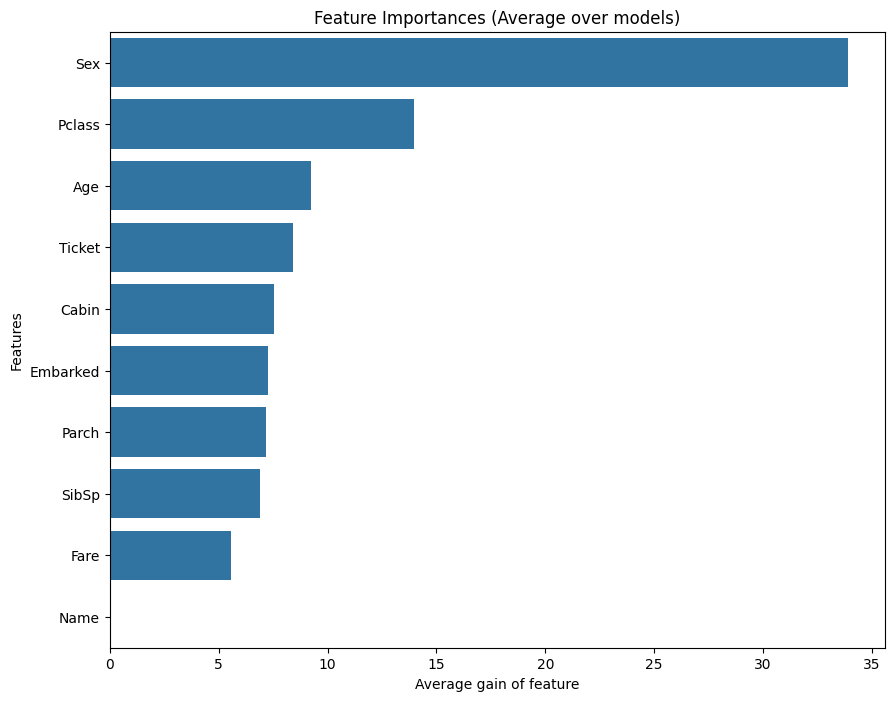

In [7]:
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.title('Feature Importances (Average over models)')
plt.xlabel('Average gain of feature')
plt.ylabel('Features')
plt.show()

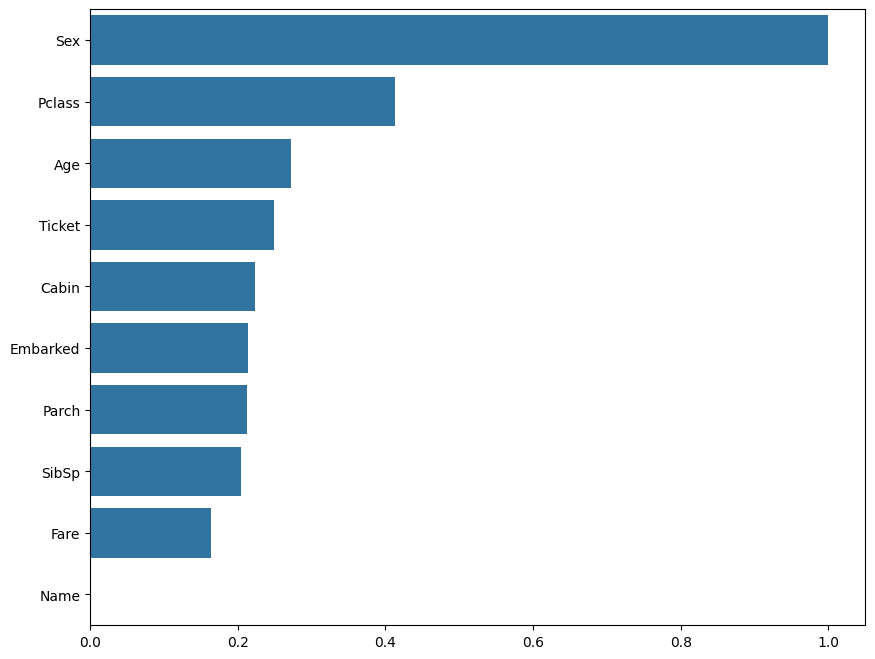

In [8]:
max_importance = max(sorted_importances)
importance_ratios = [x / max_importance for x in sorted_importances]
plt.figure(figsize=(10, 8))
sns.barplot(x=importance_ratios, y=sorted_features)
plt.show()

In [9]:
important_features = [name  for name, ratio in zip(sorted_features, importance_ratios) if ratio>0.1]
important_features

['Sex',
 'Pclass',
 'Age',
 'Ticket',
 'Cabin',
 'Embarked',
 'Parch',
 'SibSp',
 'Fare']

In [10]:
important_features = [name  for name, ratio in zip(sorted_features, importance_ratios) if ratio>0.2]
important_features

['Sex', 'Pclass', 'Age', 'Ticket', 'Cabin', 'Embarked', 'Parch', 'SibSp']